### Welcome to Trident: A Python Package for Whole-Slide Image Processing 


This tutorial will guide you step-by-step to process a single whole-slide image (WSI) using Trident:

- Tissue vs. background segmentation 
- Tissue coordinate extraction
- Tissue feature extraction


#### 0- Installation 


```
conda create -n "trident" python=3.10
conda activate trident
git clone git@github.com:mahmoodlab/trident.git && cd trident
pip install . -e

```

Please refer to the FAQ if you face installation issues.

#### 1- Tissue vs background segmentation

Fetching 1 files:   0%|          | 0/1 [00:00<?, ?it/s]

Using cache found in /home/guillaume/.cache/torch/hub/pytorch_vision_v0.10.0


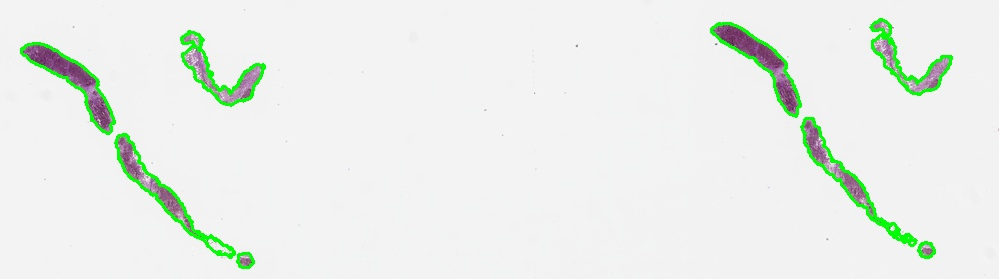

,tissue_id,geometry
0,0,"POLYGON ((14593 15120, 14584 15128, 14576 1512..."
1,1,"POLYGON ((55307 14492, 55299 14500, 55290 1450..."
2,2,"POLYGON ((7484 8053.9, 7483.99 8053.9, 7483.98..."
3,3,"POLYGON ((48157 7108, 48157 7116, 48157 7124, ..."
4,4,"POLYGON ((2009 2587, 2000 2595, 1992 2595, 198..."
5,5,"POLYGON ((11311 1907.9, 11310.99 1907.9, 11310..."
6,6,"POLYGON ((43251 1389, 43243 1398, 43234 1398, ..."
7,7,"POLYGON ((52561 1155, 52553 1163, 52544 1172, ..."


In [11]:
import os
import torch 
from PIL import Image
import geopandas as gpd
from IPython.display import display
from huggingface_hub import snapshot_download

from trident.wsi_objects.WSI import OpenSlideWSI
from trident.segmentation_models.load import segmentation_model_factory

# a. Download a WSI
OUTPUT_DIR = "tutorial-1/"
DEVICE = f"cuda:0" if torch.cuda.is_available() else "cpu"
WSI_FNAME = '394140.svs'
os.makedirs(OUTPUT_DIR, exist_ok=True)
local_wsi_dir = snapshot_download(
    repo_id="MahmoodLab/unit-testing",
    repo_type='dataset',
    local_dir=os.path.join(OUTPUT_DIR, 'wsis'),
    allow_patterns=[WSI_FNAME]
)

# b. Create OpenSlideWSI
wsi_path = os.path.join(local_wsi_dir, WSI_FNAME)
slide = OpenSlideWSI(slide_path=wsi_path, lazy_init=False)

# c. Run segmentation 
segmentation_model = segmentation_model_factory("hest", device=DEVICE)
geojson_contours = slide.segment_tissue(segmentation_model=segmentation_model, target_mag=10, job_dir=OUTPUT_DIR)

# d. Visualize contours
contour_image = Image.open(os.path.join(OUTPUT_DIR, 'contours', WSI_FNAME.replace('.svs', '.jpg')))
display(contour_image)

# e. Check contours saved into GeoJSON with GeoPandas
gdf = gpd.read_file(geojson_contours)
gdf.head(n=10)


#### 2- Tissue coordinate extraction

We are patching the whole-slide image into non-overlapping patches of size 256x256 at 20x magnification (0.5 um/px).

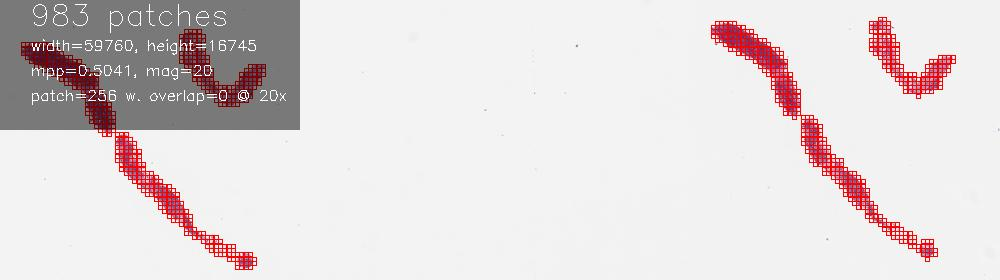

Contents and Attributes of the HDF5 file:
Object: coords
  Attribute - level0_magnification: 20
  Attribute - name: 394140
  Attribute - overlap: 0
  Attribute - patch_size: 256
  Attribute - patch_size_level0: 256
  Attribute - savetodir: tutorial-1/
  Attribute - target_magnification: 20


In [20]:
import h5py 

TARGET_MAG = 20
PATCH_SIZE = 256

# a. Run patch coordinate extraction
coords_path = slide.extract_tissue_coords(
    target_mag=TARGET_MAG,
    patch_size=PATCH_SIZE,
    save_coords=OUTPUT_DIR
)

# b. Visualize
viz_coords_path = slide.visualize_coords(
    coords_path=coords_path,
    save_patch_viz=os.path.join(OUTPUT_DIR, "visualization")
)
display(Image.open(viz_coords_path))

# c. Inspect h5 with patch coordinates 
def print_attrs(name, obj):
    print(f"Object: {name}")
    for key, value in obj.attrs.items():
        print(f"  Attribute - {key}: {value}")

with h5py.File(coords_path, 'r') as h5_file:
    print("Contents and Attributes in patch coords file:")
    h5_file.visititems(print_attrs)

#### 3- Patch feature extraction with the UNI model


In [23]:
from trident.patch_encoder_models.load import encoder_factory

PATCH_ENCODER = "uni_v1" # Visit the factory or check the README for a list of all available models

# a. Instantiate UNI model using the factory 
encoder = encoder_factory(PATCH_ENCODER)
encoder.eval()
encoder.to(DEVICE)

# b. Run UNI feature extraction
features_dir = os.path.join(OUTPUT_DIR, f"features_{PATCH_ENCODER}")
feats_path = slide.extract_patch_features(
    patch_encoder=encoder,
    coords_path=coords_path,
    save_features=features_dir,
    device=DEVICE
)

# c. Inspect h5 with patch features 
with h5py.File(feats_path, 'r') as h5_file:
    print("Contents and Attributes in feats file:")
    h5_file.visititems(print_attrs)


Contents and Attributes in feats file:
Object: coords
  Attribute - level0_magnification: 20
  Attribute - name: 394140
  Attribute - overlap: 0
  Attribute - patch_size: 256
  Attribute - patch_size_level0: 256
  Attribute - savetodir: tutorial-1/
  Attribute - target_magnification: 20
Object: features
  Attribute - name: 394140
  Attribute - savetodir: tutorial-1/features_uni_v1
